In [234]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline 

matplotlib.rc('figure', figsize=(12, 5))
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 16}

matplotlib.rc('font', **font)

In [308]:
# from http://zyxue.github.io/2017/09/21/python-timeit-decorator.html
import datetime
import time
from functools import wraps
from typing import Any, Callable


def timeit(func: Callable[..., Any]) -> Callable[..., Any]:
    """Times a function, usually used as decorator"""

    @wraps(func)
    def timed_func(*args: Any, **kwargs: Any) -> Any:
        """Returns the timed function"""
        start_time = time.time()
        result = func(*args, **kwargs)
        elapsed_time = datetime.timedelta(seconds=(time.time() - start_time))
        print("time spent on %s: %s", func.__name__, elapsed_time)
        return result

    return timed_func


# SAT Solver

In [10]:
pip install dd

     |████████████████████████████████| 419kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 153kB 31.4MB/s eta 0:00:01
  Using cached https://files.pythonhosted.org/packages/33/d1/b1479a770f66d962f545c2101630ce1d5592d90cb4f083d38862e93d16d2/pydot-1.4.1-py2.py3-none-any.whl
  Created wheel for dd: filename=dd-0.5.5-cp37-none-any.whl size=385499 sha256=6caab681ad8a9a1fa15b0fff9ae5e49f06862c633753c178dc5fc5d79e7375b7
  Stored in directory: /home/ben/.cache/pip/wheels/02/8a/67/7e6e05bf793d9401ef13b5553dd256e868d4f99035d0756c26
  Created wheel for astutils: filename=astutils-0.0.4-cp37-none-any.whl size=5728 sha256=b561bf924b888aaff2270f170e5a927c125cfe6160ec7a841c98996ebd876da0
  Stored in directory: /home/ben/.cache/pip/wheels/44/22/ae/e92c1332094a30f8a3233c149412938791932562bd538612e1
  Created wheel for ply: filename=ply-3.10-py2.py3-none-any.whl size=48435 sha256=4b7c09ddc7d260d21652c96df8d9605dfbe472069dbef489e66e4aba4c8e210e
  Stored in directory: /home/ben/.cache/pip/w

In [12]:
pip install omega

     |████████████████████████████████| 204kB 2.7MB/s eta 0:00:01
     |████████████████████████████████| 71kB 14.5MB/s eta 0:00:01
  Created wheel for omega: filename=omega-0.3.1-cp37-none-any.whl size=107785 sha256=6d8688d7754aba70f82a6b6fadc2d9ba559c8f860e7801983a071840c9bdad1c
  Stored in directory: /home/ben/.cache/pip/wheels/eb/63/fd/1e9e1346e8ba5b7417d687e996308015e2838439f5ec6272f6
Successfully built omega
Note: you may need to restart the kernel to use updated packages.


In [304]:
import seaborn as sns; sns.set()

def visualize_solution(solution):
    """visualize a board of arbitrary size"""
    if isinstance(solution, dict):
        solution = list(solution.values())
    if isinstance(solution, list):
        solution = np.array(solution)
    
    n = int(np.sqrt(solution.size))
    plt.figure(figsize=(5, 3))
    sns.heatmap(
        solution.reshape((n, n)),
        cbar=False,
        cmap="YlGnBu",
        annot=True
    )
    plt.show()

In [306]:
"""
From the dd examples on github:
https://github.com/tulip-control/dd/blob/0f6d16483cc13078edebac9e89d1d4b99d22991e/examples/queens.py

N-Queens problem using one-hot encoding.
Reference
=========
Henrik R. Andersen
    "An introduction to binary decision diagrams"
    Lecture notes for "Efficient Algorithms and Programs", 1999
    The IT University of Copenhagen
    Sec.6.1
"""
import pickle
import time
from dd import bdd as _bdd
from omega.logic.syntax import conj, disj


def solve_queens(n):
    """Return set of models for the `n`-queens problem.
    @rtype: `int`, `BDD`
    """
    vrs = [_var_str(i, j) for i in range(n) for j in range(n)]
    bdd = _bdd.BDD()
    bdd.declare(*vrs)
    s = queens_formula(n)
    u = bdd.add_expr(s)
    return u, bdd


def queens_formula(n):
    """Return a non-trivial propositional formula for the problem."""
    # i = row index
    # j = column index
    present = at_least_one_queen_per_row(n)
    rows = at_most_one_queen_per_line(True, n)
    cols = at_most_one_queen_per_line(False, n)
    slash = at_most_one_queen_per_diagonal(True, n)
    backslash = at_most_one_queen_per_diagonal(False, n)
    s = conj([present, rows, cols, slash, backslash])
    return s


def at_least_one_queen_per_row(n):
    """Return formula as `str`."""
    c = list()
    for i in range(n):
        xijs = [_var_str(i, j) for j in range(n)]
        s = disj(xijs)
        c.append(s)
    return conj(c)


def at_most_one_queen_per_line(row, n):
    """Return formula as `str`.
    @param row: if `True`, then constrain rows, else columns.
    """
    c = list()
    for i in range(n):
        if row:
            xijs = [_var_str(i, j) for j in range(n)]
        else:
            xijs = [_var_str(j, i) for j in range(n)]
        s = mutex(xijs)
        c.append(s)
    return conj(c)


def at_most_one_queen_per_diagonal(slash, n):
    """Return formula as `str`.
    @param slash: if `True`, then constrain anti-diagonals,
        else diagonals.
    """
    c = list()
    if slash:
        a = -n
        b = n
    else:
        a = 0
        b = 2 * n
    for k in range(a, b):
        if slash:
            ij = [(i, i + k) for i in range(n)]
        else:
            ij = [(i, k - i) for i in range(n)]
        ijs = [(i, j) for i, j in ij if 0 <= i < n and 0 <= j < n]
        if not ij:
            continue
        xijs = [_var_str(i, j) for i, j in ijs]
        s = mutex(xijs)
        c.append(s)
    return conj(c)


def mutex(v):
    """Return formula for at most one variable `True`.
    @param v: iterable of variables as `str`
    """
    v = set(v)
    c = list()
    for x in v:
        rest = disj(y for y in v if y != x)
        s = '{x} -> !({rest})'.format(x=x, rest=rest)
        c.append(s)
    return conj(c)


def _var_str(i, j):
    """Return variable for occupancy of cell at {row: i, column: j}."""
    return 'x{i}{j}'.format(i=i, j=j)


def benchmark(n):
    """Run for `n` queens and print statistics."""
    t0 = time.time()
    u, bdd = solve_queens(n)
    t1 = time.time()
    dt = t1 - t0
    
    for i, d in enumerate(bdd.pick_iter(u)):
        if len(d) > 0:
            visualize_solution(d)
            break
    n_solutions = bdd.count(u)

    s = (
        '------\n'
        'queens: {n}\n'
        'time: {dt} (sec)\n'
        'node: {u}\n'
        'total nodes: {k}\n'
        'number solutions: {n_solutions}\n'
        '------\n'
    ).format(
        n=n, dt=dt, u=u, k=len(bdd),
        n_solutions=n_solutions,
    )
    print(s)
    return dt

------
queens: 0
time: 0.0014064311981201172 (sec)
node: 1
total nodes: 1
number solutions: 1
------



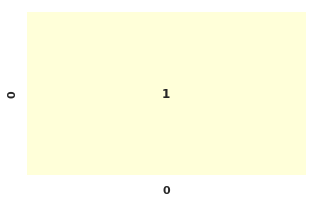

------
queens: 1
time: 0.0006928443908691406 (sec)
node: 2
total nodes: 2
number solutions: 1
------

------
queens: 2
time: 0.0030727386474609375 (sec)
node: -1
total nodes: 27
number solutions: 0
------

------
queens: 3
time: 0.012363195419311523 (sec)
node: -1
total nodes: 212
number solutions: 0
------



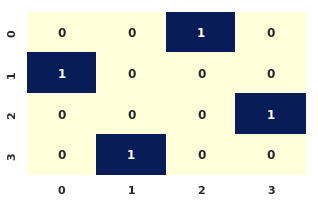

------
queens: 4
time: 0.029534578323364258 (sec)
node: -916
total nodes: 916
number solutions: 2
------



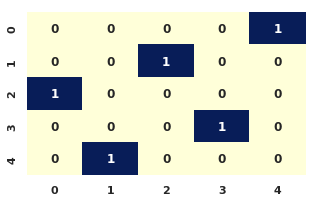

------
queens: 5
time: 0.09945130348205566 (sec)
node: -3637
total nodes: 3637
number solutions: 10
------



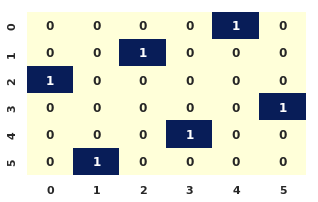

------
queens: 6
time: 0.28052210807800293 (sec)
node: -13440
total nodes: 13440
number solutions: 4
------



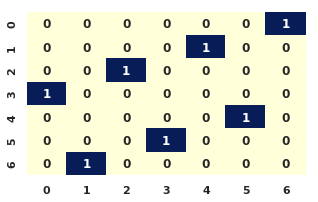

------
queens: 7
time: 1.0390377044677734 (sec)
node: -55822
total nodes: 55822
number solutions: 40
------



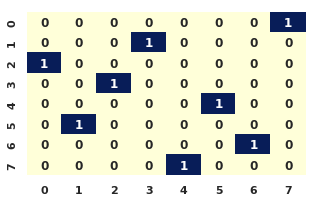

------
queens: 8
time: 4.775595426559448 (sec)
node: -250797
total nodes: 250797
number solutions: 92
------



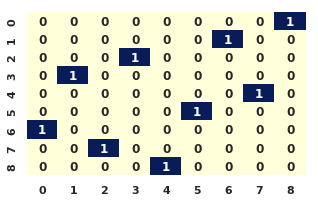

------
queens: 9
time: 23.82765531539917 (sec)
node: -1200072
total nodes: 1200072
number solutions: 352
------



In [307]:
n_max = 9
fname = 'dd_times.p'
times = dict()
for n in range(n_max + 1):
    t = benchmark(n)
    times[n] = t
f = open(fname, 'wb')
pickle.dump(times, f)

# Genetic algorithm

In [350]:
def plot_scores(scores):
    plt.plot(
        list(range(len(scores))),
        scores,
        '--o',
    )
    plt.ylabel('score')
    plt.xlabel('iterations')

In [312]:
import numpy as np
from numba import jit

@jit(nopython=True)
def cost_function(props) -> int:
    """Given a props vector from a particle,
    a vector of queens' positions, how right are we?"""
    res: int = 0
    for i1, q1 in enumerate(props[:-1]):
        for i2, q2 in enumerate(props[i1+1:], i1+1):
            if (q1 != q2) and (abs(i1 - i2) != abs(q1 - q2)):
                res += 1
    return res

In [1]:
import chess
import chess.svg
from IPython.display import display

def queen_to_str(q, N=8):
    prev = str(q) if q > 0 else ''
    post = str((N-1)-q) if q < (N-1) else ''
    return prev + 'Q' + post

assert queen_to_str(1) == '1Q6'
assert queen_to_str(0) == 'Q7'
assert queen_to_str(7) == '7Q'

def show_board(queens):
    """This only works for 8 queens..."""
    fen = '/'.join([queen_to_str(q) for q in queens])
    display(chess.svg.board(board=chess.Board(fen), size=300))
    
solution = np.array([2, 4, 6, 8, 3, 1, 7, 5]) - 1
show_board(solution)

NameError: name 'np' is not defined

In [352]:
import random
from typing import Optional, List, Tuple

class Chromosome:
    def __init__(self, configuration: Optional[List]=None, nq: Optional[int]=None):
        """make sure either nq or configuration is given!
        """
        assert not (nq is None and configuration is None)
        if configuration is None:
            self.nq = nq
            self.max_fitness = np.sum(np.arange(nq))
            self.configuration = [
                random.randint(1, nq) for _ in range(nq)
            ]
        else:
            self.configuration = configuration
            self.nq = len(configuration)
            self.max_fitness = np.sum(np.arange(self.nq))
    
    def fitness(self):
        return cost_function(self.configuration) / self.max_fitness

    def mutate(self):
        """A mutation: randomly changing a value
        inside a chromosome"""
        ind = random.randint(0, self.nq-1)
        val = random.randint(1, self.nq)
        self.configuration[ind] = val

class GeneticQueen:
    def __init__(self, nq, population_size=20, mutation_prob=0.5):
        self.nq = nq
        self.population_size = population_size
        self.mutation_prob = mutation_prob
        self.population = [Chromosome(nq=nq) for _ in range(population_size)]
        self.solution = None
        self.best_fitness = None

    def iterate(self):
        """create a new generation
        """
        new_population = []
        best_fitness = -1
        for i in range(len(self.population)):
            p1, p2 = self.get_parents()
            child = Chromosome(self.cross_over(p1, p2))
            
            if random.random() < self.mutation_prob:
                child.mutate()
                
            new_population.append(child)
            fit = child.fitness()
            if fit > best_fitness:
                best_fitness = fit
            if fit == 1:
                self.solution = child
                break
                
        self.best_fitness = best_fitness
        self.population = new_population
        
    def cross_over(self, p1, p2):
        """cross_over between two chromosomes
        """
        return [
            yi
            if random.random() > 0
            else xi
            for xi, yi in zip(
                p1.configuration,
                p2.configuration
            )
        ]
    
    def get_parents(self) -> Tuple[Chromosome, Chromosome]:
        """choose parents to reproduce;
        fittest more likely to be chosen
        """
        weights = [chrom.fitness() for chrom in self.population]
        return tuple(
            random.choices(
                self.population, 
                weights=weights,
                k=2
            )
        )
    
    def visualize_solution(self):
        """visualize a board of arbitrary size"""
        if self.nq == 8:
            show_board(np.array(self.solution.configuration)-1)
        else:
            board = np.zeros(shape=(self.nq, self.nq))
            for row, col in enumerate(self.solution.configuration):
                board[row, col-1] = 1
            plt.figure(figsize=(5, 3))
            sns.heatmap(
                board,
                cbar=False,
                cmap="YlGnBu",
                annot=True
            )
            plt.show()

@timeit
def ga_solver(nq):
    fitness_trace = []
    gq = GeneticQueen(nq=nq)
    generation = 0
    while not gq.solution:
        gq.iterate()
        if (generation % 100) == 0:
            print('Generation {}'.format(generation))
            print('Maximum Fitness = {:.3f}'.format(gq.best_fitness))
        fitness_trace.append(gq.best_fitness)
        generation += 1

    gq.visualize_solution()
    return fitness_trace

=== Generation 0 ===
Maximum Fitness = 0.8571428571428571
=== Generation 100 ===
Maximum Fitness = 0.8214285714285714
=== Generation 200 ===
Maximum Fitness = 0.8928571428571429
=== Generation 300 ===
Maximum Fitness = 0.8928571428571429
=== Generation 400 ===
Maximum Fitness = 0.8928571428571429


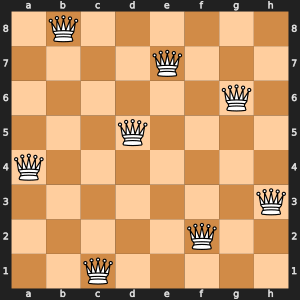

time spent on %s: %s ga_solver 0:00:07.453955


In [353]:
fitness_trace = ga_solver(8)

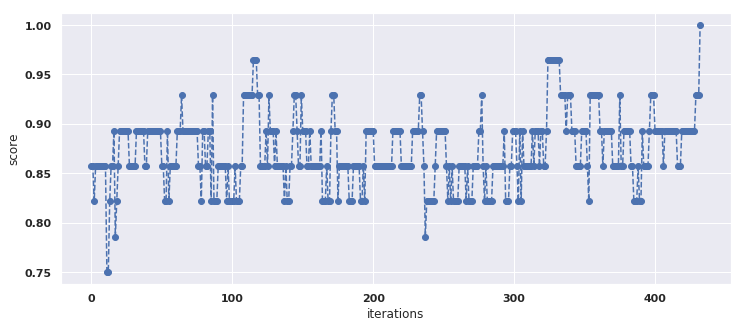

In [354]:
plot_scores(fitness_trace)

# Particle Swarm Optimization

In [313]:
SOLVED_COST = np.sum(np.arange(NQUEENS))
assert SOLVED_COST == 28

In [167]:
# loosely based on https://github.com/luckeciano/ita-artificial-intelligence-PSO/blob/master/PSO.cpp
class Particle:
    best_fitness: int = 0
    
    def __init__(
        self, N=None, props=None,
        velocities=None
    ):
        """Either specify N for randomization,
        or props and velocities
        """
        if props is None:
            # random initialization
            self.current_particle = np.random.randint(0, N-1, N)
            self.best_state = np.random.randint(0, N-1, N)
            self.velocities = np.random.uniform(-(N-1), N-1, N)
        else:
            self.current_particle = props
            self.best_state = props
            self.velocities = velocities
    
        self.best_fitness = cost_function(self.best_state)
                
    def set_new_best(self, props: List[int], new_fitness: int):    
        self.best_state = props
        self.best_fitness = new_fitness
        
    def __repr__(self):
        return f'{self.__class__.__name__}(\n' +\
            f'\tcurrent_particle={self.current_particle}\n'  +\
            f'\best_state={self.best_state}\n'  +\
            f'\tvelocities={self.velocities}\n'  +\
            f'\best_fitness={self.best_fitness}\n'  +\
            ')'

In [168]:
def init_particles(N: int, n_particles: int):
    return [Particle(N=N) for i in range(n_particles)]

particles = init_particles(8, 20)

In [170]:
particles[0]

Particle(
	current_particle=[0 3 0 1 3 6 4 3]
est_state=[0 5 2 1 4 3 1 2]
	velocities=[ 1.27154284 -5.61595698 -4.95730288  3.8275404   5.40571384  2.55526268
 -4.6717073   1.28737144]
est_fitness=19
)

In [169]:
particles[0].current_particle

array([0, 3, 0, 1, 3, 6, 4, 3])

In [160]:
particles[0].current_particle

array([0, 0, 0, 0, 0, 0, 0, 0])

In [161]:
cost_function(np.array([7, 9, 3, 8, 2, 4, 6, 1]))

28

In [47]:
(NQUEENS-1)*(NQUEENS-1)

49

In [6]:
particles[0]

Particle(
	current_particle=[3 4 4 3 0 3 1 4]
est_state=[3 4 4 3 0 3 1 4]
	velocities=[ 1.20748849 -7.05867763  5.96828772 -7.49691265  0.29851909 -6.64556426
 -2.4222154  -4.22005676]
est_fitness=-1
)

In [171]:
# cdef int[:] get_best_particle(list particles):
# def get_best_particle(particles: List[Particles]) -> Particle:

@jit(nopython=False)
def get_best_particle(particles):
    best_particle = 0  # int
    best_score = -1  # int
    score = -1  # int
    for i, particle in enumerate(particles):
        score = cost_function(particle.current_particle)
        if score > best_score:
            best_score = score
            best_ind = i
    return particles[best_ind].current_particle, best_score

In [176]:
particles = particles[:-1]

In [180]:
particles.append(Particle(props=solution))

In [181]:
get_best_particle(particles)  #  == (solution, 28)

(array([1, 3, 5, 7, 2, 0, 6, 4]), 28)

In [44]:
particles[0]

Particle(
	current_particle=[3 4 4 3 0 3 1 4]
est_state=[3 4 4 3 0 3 1 4]
	velocities=[ 1.20748849 -7.05867763  5.96828772 -7.49691265  0.29851909 -6.64556426
 -2.4222154  -4.22005676]
est_fitness=-1
)

In [ ]:
# good explanation and pseudocode https://en.wikipedia.org/wiki/Particle_swarm_optimization

In [229]:
def particle_swarm_optimization(
    N: int, omega: float, phip: float, phig: float,
    n_particles: int, visualize=False, max_iteration=999999
) -> List[int]:
    """Particle Swarm Optimization
    
    Parameters:
    -----------
    N - number of queens
    omega - a decay parameter
    phip - controls the contribution of the local search
    phig - controls the contribution of the global search
    n_particles - the number of particles
    visualize - if the solutions should be visualized by images
    max_iteration - for early stopping
    
    Returns:
    --------
    best_particle - the best solution
    scores - the best scores over iterations
    
    Highly sensitive to the choice of parameters!
    """
    def print_best():
        print(f'iteration {iteration} - best particle: {best_particle}, score: {best_score}')

    solved_cost = np.sum(np.arange(N))
    particles = init_particles(N=N, n_particles=n_particles)
    iteration = 0
    best_particle, best_score = get_best_particle(particles)
    scores = [ best_score ]
    if visualize:
        print('iteration:', iteration)
        show_board(best_particle)
    while best_score < solved_cost and iteration < max_iteration:
        if (iteration % 500) == 0 or iteration == 0:
            print_best()
        
        for particle in particles:
            rg = np.random.rand((N))
            rp = np.random.rand((N))
            delta_p = particle.best_state - particle.current_particle
            delta_g = best_particle - particle.current_particle
            update = (rp * phip * delta_p +\
                rg * phig * delta_g)     # local vs global
            #print('particle:')
            #print(delta_p)
            #print(delta_g)
            #print(update)
            particle.velocities = omega * particle.velocities + update
            #print(particle.velocities)
            particle.current_particle = (
                np.abs(particle.current_particle + particle.velocities) % N
            ).astype(int)
            # update the particle best
            current_fitness = cost_function(particle.current_particle)
            if current_fitness > particle.best_fitness:
                particle.set_new_best(particle.current_particle, current_fitness)
            
        best_particle_cand, best_score_cand = get_best_particle(particles)
        if best_score_cand > best_score:
            best_particle, best_score = best_particle_cand, best_score_cand
            if iteration > 0 and visualize:
                print('iteration:', iteration)
                show_board(best_particle)
        scores.append(best_score)
        iteration += 1

    print_best()
    return best_particle, scores

iteration: 0


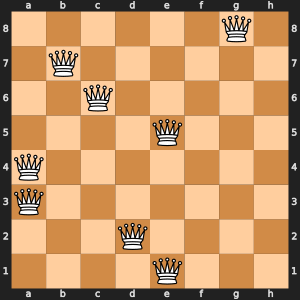

iteration 0 - best particle: [6 1 2 4 0 0 3 4], score: 23
iteration: 3


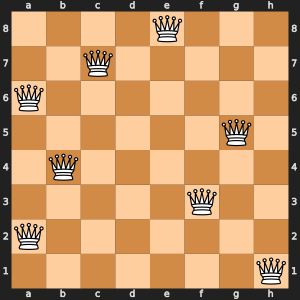

iteration: 32


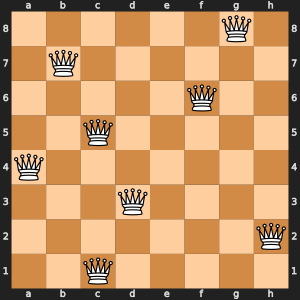

iteration 500 - best particle: [6 1 5 2 0 3 7 2], score: 27
iteration 1000 - best particle: [6 1 5 2 0 3 7 2], score: 27
iteration: 1322


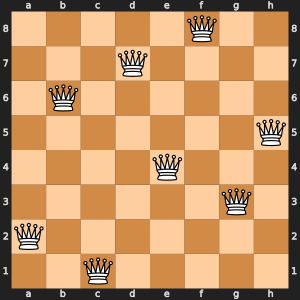

iteration: 1323


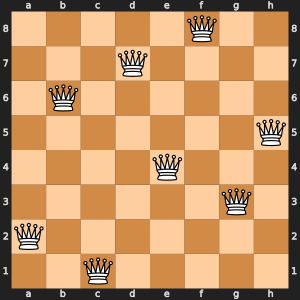

iteration 1323 - best particle: [5 3 1 7 4 6 0 2], score: 28


In [230]:
best_particle, scores = particle_swarm_optimization(
    N=8, omega=1, phip=8, phig=2,
    n_particles=50, visualize=True
)

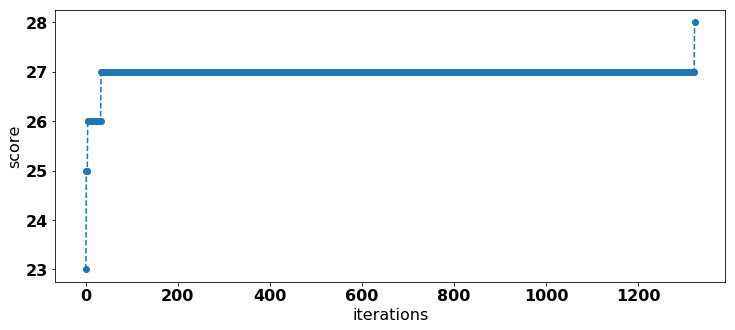

In [231]:
plot_scores(scores)

In [ ]:
https://github.com/microsoft/PDP-Solver

In [ ]:
solving sudoku https://codingnest.com/modern-sat-solvers-fast-neat-underused-part-1-of-n/

In [ ]:
# solving n-queens as a logic problem https://github.com/pcarbonn/pyDatalog/blob/0d59ddeaf51b04d902e5b3c1cd8ad95a0e0e7099/pyDatalog/examples/queens.py#L48

about kings and knaves with z3:
* https://jamiecollinson.com/blog/solving-knights-and-knaves-with-z3/
